<a href="https://colab.research.google.com/github/AuraFrizzati/NHSW-NHFD-Web-Scraper/blob/main/V2_GoogleColab_NHFD_WebScraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NHFD web scraper (V2 - Dec 2025)**
Script to web scrape Hip Fracture data from the [National Hip Fracture Database (NHFD)](https://www.nhfd.co.uk/)

1. Press the play button in the cell below to run the webscraper. The data will be collated into 4 different tables (each table contains the data for *all* sites):
- [Denoms](https://www.nhfd.co.uk/20/NHFDcharts.nsf/vwCharts/KPIsOverview) --> `NHFD_Data_Extraction_Collection_*.csv`
- [Key Performance](https://www.nhfd.co.uk/20/NHFDcharts.nsf/vwCharts/KPIs) --> `NHFD_KPI_*.csv`
- [Length Of Stay](https://www.nhfd.co.uk/20/NHFDcharts.nsf/vwCharts/LengthOfStay) --> `NHFD_LOS_*.csv`
- [Overall Performance](https://www.nhfd.co.uk/20/NHFDCharts.nsf/Charts/OverallPerformance) --> `NHFD_OP_*.csv`

2. Check the text in the output cell to ensure the webscraping was successful

3. Retrieve the zipped `NHFD_data.zip` folder from Google Colab cloud by clicking on the files section (folder icon) on the left and then hover with the mouse on `NHFD_data.zip` --> click on the three vertical dots and click on download

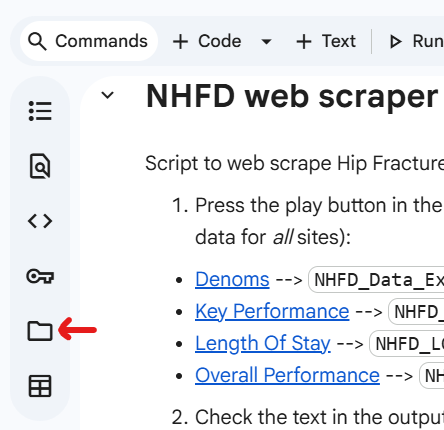



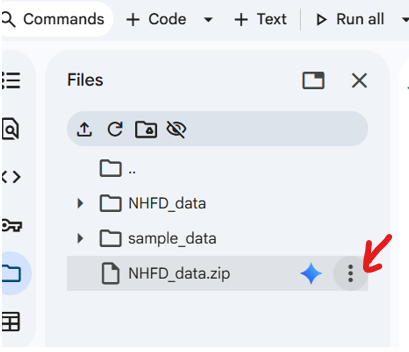

4. Extract the files from `NHFD_data.zip` and upload them in the project GCP bucket

In [ ]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
from datetime import datetime
import pytz
import os
import re
from requests.adapters import HTTPAdapter
from urllib3.util import Retry
import sys
import shutil

## manual selection of websites to scrape (if True, the specific dataset will be downloaded, change to False if you do not want to download it)
denoms = True
kpi = True
los = True
op = True

def setup():
    # Create a fixed directory path to save the file
    directory_path = 'NHFD_data'
    # Ensure the directory exists (create it if needed)
    os.makedirs(directory_path, exist_ok=True)

    # setting up timestamp
    date_of_scrape = datetime.now(pytz.timezone("Europe/London")).strftime("%Y-%m-%d %H:%M:%S")
    date_of_scrape_file_name_tag =date_of_scrape.replace(":", "_").replace(" ", "__")

    # Hospital sites of interest
    site_list = [
    "[ALL]",
    "[England]",
    "[Wales]",
    "[NI]",
    "BRG",
    "CLW",
    "GWE",
    "GWY",
    "MOR",
    "PCH",
    "POW",
    "RGH",
    "UHW",
    "WRX",
    "WWG",
    "WYB"
    ]

    # Define the retry strategy
    # https://www.zenrows.com/blog/python-requests-retry#status-codes
    retry_strategy = Retry(
        total=4,  # Maximum number of retries
        status_forcelist=[429, ## Too Many Requests
                        500, ## Internal Server Error
                        502, ## 502 Bad Gateway
                        503, ## 503 Service Unavailable
                        504 ## 504 Gateway Timeout
                        ],  # HTTP status codes to retry on
    )
    # Create an HTTP adapter with the retry strategy and mount it to session
    adapter = HTTPAdapter(max_retries=retry_strategy)

    # Create a new session object and attach the retry strategy to it
    session = requests.Session()
    session.mount('https://', adapter)
    session.headers.update({'User-Agent': 'Mozilla/5.0'})
    return directory_path, date_of_scrape,date_of_scrape_file_name_tag, site_list, session

def scrape_plot_data(
        category,
        # directory_path,
        date_of_scrape,
        site_list,
        session,
        div,
        url,
        html_labels,
        columns_order,
        columns_names):

    combined_frames = []

    for x in range(len(site_list)):
        print(div)
        complete_url = f"{url}{site_list[x]}"
        print(f"extracting {category} data for {site_list[x]} from {complete_url} ...")
        try:
            result = session.get(url)
            result.raise_for_status()  # Raises HTTPError for bad responses (4xx, 5xx)

            doc = BeautifulSoup(result.text, "html.parser")  # Parse Content
            scripts = '\n'.join([script.text for script in doc.find_all("script")])

            # Regex to extract data as tuples with 3 elements: ((before =),(=),(after = and up to ;)).
            # view-source example:https://www.nhfd.co.uk/20/NHFDcharts.nsf/vwCharts/KPIs?open&org=WWG (DATA1 first block)
            # Example: ( (var cats), (=), (['Jan 2017','Feb 2017','Mar 2017','Apr 2017'...];) )
            # The 3-part tuple for each list item will always match the below Index positions:
            # [0] = variable name (i.e. var cat)
            # [1] = will always be the string '='
            # [2] = the content of the variable (a series of values)
            match_scripts = re.findall(r"(.*)( = )([^;]*)", scripts)

            # labels to filter match scripts via their first element [0] (these contain the data)
            match_scripts_labels = html_labels

            # Extract data as a dictionary using list comprehension, in the form {match_scripts_label: [data series]}
            df_dict = {
                match_scripts[i][0].strip(): [val.strip() for val in match_scripts[i][2].replace("[", "").replace("]", "").replace("'", "").replace("null", "").strip().split(",")]
                for i in range(len(match_scripts))
                if match_scripts[i][0] in match_scripts_labels
            }

            # check length of values expected (some series are empty/shorter at the end and require padding wiht blank values)
            max_length = max(len(values) for values in df_dict.values())
            # Pad all lists in the dictionary to match the maximum length
            df_dict = {
                key: values + [""] * (max_length - len(values))
                for key, values in df_dict.items()
            }

            # convert the dictionary to pandas df
            df = pd.DataFrame(df_dict)

            new_order = columns_order
            df = df[new_order]

            # Rename Columns to match the NHFD website
            df.rename(columns = columns_names,
            inplace=True
            )
            df["file_name"] = f'NHFD_{site_list[x]}_{category}_{date_of_scrape.replace(":", "_")}.csv'
            df["upload_date"] = date_of_scrape
            print(f"KPI data webscraping completed for {site_list[x]}")
            combined_frames.append(df)

        except Exception as e:
            print(f"Error fetching data for {site_list[x]}: {e}")
            sys.exit(1)

    return combined_frames


def denoms_webscraper(directory_path, date_of_scrape, site_list, session, div):
    combined_frames = []

    ### [1a] Webscrape Denoms
    sentences_list = []
    month_end_list = []
    cases_list = []
    k0_list = []
    k1_list = []
    k2_list = []
    k3_list = []
    k4_list = []
    k5_list = []
    k6_list = []
    k7_list = []

    try:
        #print(div)
        #print(f"extracting Denoms data...")
        for x in range(len(site_list)):

            url = f"https://www.nhfd.co.uk/20/NHFDcharts.nsf/vwCharts/KPIsOverview?open&org={site_list[x]}"

            result = session.get(url)
            result.raise_for_status()  # Raises HTTPError for bad responses (4xx, 5xx)

            doc = BeautifulSoup(result.text, "html.parser")  # Parse Content

            # [1] find the descriptive text in the html code
            # e.g. "Annualised values based on 70,617 cases averaged over 12 months.."
            sentence = doc.find_all('div', {'class': 'note'})[0].text.replace('\n', '')
            sentences_list.append(sentence)

            # [2] find the KPI numeric data in the html code
            data = doc.find_all('div', {'class': 'annual'})
            kpi_data = []

            for i in data:
                kpi_data.append(i.text)

            # [3] Create lists by KPI type
            k0_list.append(kpi_data[0])
            k1_list.append(kpi_data[1])
            k2_list.append(kpi_data[2])
            k3_list.append(kpi_data[3])
            k4_list.append(kpi_data[4])
            k5_list.append(kpi_data[5])
            k6_list.append(kpi_data[6])
            k7_list.append(kpi_data[7])

            # [4] Extract Month and Year from descriptive text webscraped in [1]

            # Look for one or more word characters `(\w+)`, followed by one or more whitespaces `\s+`,
            # followed by exactly 4 digits `(\d{4})`
            match = re.search(r'(\w+)\s+(\d{4})', sentence)

            # Get the word and the 4 digits groups and divide them by a blank space
            month_year_str = match.group(1) + ' ' + match.group(2)

            #  Use `datetime.strptime` to parse the "Month YYYY" as a date,
            # then use `.strftime` to convert it to a string with the format yyyy-mm-dd
            month_year_date = datetime.strptime(month_year_str, "%B %Y").strftime("%Y-%m-%d")

            month_end_list.append(month_year_date)

            # [5] Extract the number of cases from descriptive text webscraped in [1]
            cases_list.append(sentence.partition("on")[2].split()[0])

        NHFD_KPI_collection_list = []

        for i in range(len(site_list)):

            NHFD_KPI_collection_list.append(
                [
                    site_list[i],
                    # sentences_list[i], ## this was originally downloaded but possibly not required anymore?
                    month_end_list[i],
                    cases_list[i],
                    k0_list[i],
                    k1_list[i],
                    k2_list[i],
                    k3_list[i],
                    k4_list[i],
                    k5_list[i],
                    k6_list[i],
                    k7_list[i],
                    date_of_scrape
                ]
            )

        col_names = ["url","month_end","cases","k0","k1","k2","k3","k4","k5","k6","k7","date_of_scrape"]
        df = pd.DataFrame(NHFD_KPI_collection_list, columns=col_names)

        ## Remove the grouping quotes from cases numbers and convert them into integers
        df["cases"] = df["cases"].str.replace(",", "").astype(int)

        ## Convert KPI data from percentages into decimal numbers (proportions)
        for column in df.columns:
            if column.startswith("k"):
                df[column] = df[column].astype("string").str.replace("%", "").astype(float)/100


        df["upload_date"] = date_of_scrape
        #print(f"Denoms data webscraping completed")
        combined_frames.append(df)

    except Exception as e:
            print(f"Error encountered: {e}")
            sys.exit(1)

    return combined_frames

def main():

  div = "------------------------------"

  directory_path, date_of_scrape,date_of_scrape_file_name_tag, site_list, session = setup()

      # Configuration dictionary for each data type
  scraper_config = {
      'KPI': {
          'url': "https://www.nhfd.co.uk/20/NHFDcharts.nsf/vwCharts/KPIs?open&org=",
          'match_scripts_labels': ["var cats", "var kpi0", "var kpi0a", "var kpi1", "var kpi1a",
                                    "var kpi2", "var kpi2a", "var kpi3", "var kpi3a", "var kpi4",
                                    "var kpi4a", "var kpi5", "var kpi5a", "var kpi6", "var kpi6a",
                                    "var kpi7", "var kpi7a"],
          'columns_order': ["var cats", "var kpi0", "var kpi0a", "var kpi1", "var kpi1a", "var kpi2", "var kpi2a",
                            "var kpi3", "var kpi3a", "var kpi4", "var kpi4a", "var kpi5", "var kpi5a", "var kpi6",
                            "var kpi6a", "var kpi7", "var kpi7a"],
          'columns_names': {
              "var cats": "admission_year_and_month",
              "var kpi0": "admission_to_specialist_ward_pct_k0",
              "var kpi0a": "admission_to_specialist_ward_pct_k0_annual",
              "var kpi1": "prompt_orthogeriatric_review_pct_k1",
              "var kpi1a": "prompt_orthogeriatric_review_pct_k1_annual",
              "var kpi2": "prompt_surgery_pct_k2",
              "var kpi2a": "prompt_surgery_pct_k2_annual",
              "var kpi3": "nice_compliant_surgery_pct_k3",
              "var kpi3a": "nice_compliant_surgery_pct_k3_annual",
              "var kpi4": "prompt_mobilisation_pct_k4",
              "var kpi4a": "prompt_mobilisation_pct_k4_annual",
              "var kpi5": "not_delirious_postop_pct_k5",
              "var kpi5a": "not_delirious_postop_pct_k5_annual",
              "var kpi6": "return_to_original_residence_pct_k6",
              "var kpi6a": "return_to_original_residence_pct_k6_annual",
              "var kpi7": "bone_protection_medication_pct_k7",
              "var kpi7a": "bone_protection_medication_percentage_k7_annual"
          }
      },
      'LOS': {
          'url': "https://www.nhfd.co.uk/20/NHFDcharts.nsf/vwCharts/LengthOfStay?open&org=",
          'match_scripts_labels': ["var cats", "var cases", "var Ward", "var WardAve", "var Trust",
                                    "var TrustAve", "var TTW", "var TTWAve"],
          'columns_order': ["var cats", "var cases", "var Ward", "var WardAve", "var Trust",
                            "var TrustAve", "var TTW", "var TTWAve"],
          'columns_names': {
              "var cats": "trust_discharge_year_and_month",
              "var cases": "patients_number_per_month",
              "var Ward": "acute_hospital_length_of_stay_days",
              "var WardAve": "acute_hospital_length_of_stay_days_annual",
              "var Trust": "overall_trust_length_of_stay_days",
              "var TrustAve": "overall_trust_length_of_stay_days_annual",
              "var TTW": "emergency_department_outlier_length_of_stay_days",
              "var TTWAve": "emergency_department_outlier_length_of_stay_days_annual"
          }
      },
      'OP': {
          'url': "https://www.nhfd.co.uk/20/NHFDCharts.nsf/Charts/OverallPerformance?open&org=",
          'match_scripts_labels': ["var cats", "var cases", "var TTS", "var TTSAve", "var TTSAve2",
                                    "var MortPC", "var MortAve", "var MortAve2"],
          'columns_order': ["var cats", "var cases", "var TTS", "var TTSAve", "var TTSAve2",
                            "var MortPC", "var MortAve", "var MortAve2"],
          'columns_names': {
              "var cats": "admission_year_and_month",
              "var cases": "patients",
              "var TTS": "hours_to_operation",
              "var TTSAve": "hours_to_operation_annual",
              "var TTSAve2": "hours_to_operation_national",
              "var MortPC": "30_day_mortality_pct",
              "var MortAve": "30_day_mortality_pct_annual",
              "var MortAve2": "30_day_mortality_pct_national"
          }
      }
  }

  if (kpi):
      # initialise variables
      category = 'KPI'
      config = scraper_config[category]

      print(div)
      print(div)
      print(f'{category} webscraping started...')
      combined_file_name = f"NHFD_{category}_{date_of_scrape_file_name_tag}.csv"
      combined_file_path = os.path.join(directory_path, combined_file_name)

      combined_frames_KPI = scrape_plot_data(
          category,
          date_of_scrape,
          site_list,
          session,
          div,
          config['url'],
          config['match_scripts_labels'],
          config['columns_order'],
          config['columns_names']
          )

      final_df = pd.concat(combined_frames_KPI, ignore_index=True)
      final_df.to_csv(
          combined_file_path,
          index=False
      )

      print(f'{category} webscraping completed')


  if (los):
      # initialise variables
      category = 'LOS'
      config = scraper_config[category]

      print(div)
      print(div)
      print('los webscraping started...')
      combined_file_name = f"NHFD_LOS_{date_of_scrape_file_name_tag}.csv"
      combined_file_path = os.path.join(directory_path, combined_file_name)

      combined_frames_LOS = scrape_plot_data(
          category,
          date_of_scrape,
          site_list,
          session,
          div,
          config['url'],
          config['match_scripts_labels'],
          config['columns_order'],
          config['columns_names']
          )


      final_df = pd.concat(combined_frames_LOS, ignore_index=True)
      final_df.to_csv(
          combined_file_path,
          index=False
          )

      print('LOS webscraping completed')

  if (op):
      # initialise variables
      category = 'OP'
      config = scraper_config[category]

      print(div)
      print(div)
      print('OP webscraping started...')
      combined_file_name = f"NHFD_OP_{date_of_scrape_file_name_tag}.csv"
      combined_file_path = os.path.join(directory_path, combined_file_name)

      combined_frames_OP = scrape_plot_data(
          category,
          date_of_scrape,
          site_list,
          session,
          div,
          config['url'],
          config['match_scripts_labels'],
          config['columns_order'],
          config['columns_names']
      )

      final_df = pd.concat(combined_frames_OP, ignore_index=True)
      final_df.to_csv(
          combined_file_path,
          index=False
      )

      print('OP webscraping completed')

  if (denoms):
      print(div)
      print(div)
      print('Denoms webscraping started...')
      combined_file_name = f"NHFD_Data_Extraction_Collection_{date_of_scrape_file_name_tag}.csv"
      combined_file_path = os.path.join(directory_path, combined_file_name)

      combined_frames_denoms = denoms_webscraper(directory_path, date_of_scrape, site_list, session, div)


      final_df = pd.concat(combined_frames_denoms, ignore_index=True)
      final_df.to_csv(
          combined_file_path,
          index=False
          #,header=False
      )

      print('Denoms webscraping completed')

  print(div)
  print(div)
  print(f"All files saved via Colab to Files directory: {directory_path}")
  for file_name in os.listdir(directory_path):
    print(file_name)
  print(div)
  print(div)
  print(f"Wait for {directory_path} to be zipped...")

  # Define the folder name to be zipped
  folder_to_zip = directory_path

  # Define the output zip file name
  output_zip_name = directory_path

  # Check if the folder exists in the current directory
  if os.path.exists(directory_path):
      try:
          # Create a zip archive of the folder
          shutil.make_archive(directory_path, 'zip', directory_path)
          print(f"Successfully created '{directory_path}.zip' from '{directory_path}'")
          print("Process completed.")
          print(div)
      except Exception as e:
          print(f"Error zipping folder '{directory_path}': {e}")
  else:
      print(f"Folder '{directory_path}' not found in the current directory. No zip archive was created.")




if __name__ == "__main__":
    main()
